<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/5%20Procesado%20del%20lenguaje%20natural/Sesion%203/NLP_11_Topic_modeling_Gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic modeling (librería Gensim)
Vamos a ver cómo realizar un modelado de temática en grandes volúmenes de texto con la librería `gensim`  

Utilizaremos el conjunto de datos *Lee* de `Gensim` (es una versión abreviada del conjunto http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF).  

Para visualizar gráficamente los tópicos es necesario instalar la librería `pyLDAvis` dentro del entorno de Anaconda con el comando:
```python
conda install -c conda-forge pyldavis 
```

### Cargamos librerías

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import warnings

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
warnings.filterwarnings('ignore')

# spacy para lematizar
import spacy

# herramientas de dibujado
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

Utilizamos un generador para obtener los documentos del Corpus línea a línea desde el archivo del conjunto de ejemplo y convertirlos en un listado de tokens.

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/juan/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatize_doc(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """Función que devuelve el lema de una string,
    excluyendo las palabras cuyo POS_TAG no está en la lista"""
    text_out = [t.lemma_.lower() for t in nlp(text)
                if t.pos_ in allowed_postags
                and len(t.lemma_)>3
                and not t.is_stop]
    return text_out

class PreprocesaArchivo(object):
    """Pre-procesa un archivo de texto línea a línea
    Entrada: nombre del archivo de texto a procesar (string)
    Salida: iterador sobre cada línea normalizado (lista de tokens)"""
    def __init__(self, filename):
        self.filename = filename
 
    def __iter__(self):
        with open(self.filename) as f:
            for line in f:
                yield lemmatize_doc(line)

In [ ]:
data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_data_file = data_dir + os.sep + 'lee_background.cor'

In [ ]:
texto=PreprocesaArchivo(lee_data_file)

In [ ]:
for t in texto:
    print(t)
    break

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south', 'wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue', 'mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south', 'wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south', 'wales', 'rural', 'fire', 'service', 'weather', 'condition', 'cause', 'fire', 'burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south', 'wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'crane

### Creamos bigramas y trigramas
Creamos un modelo para las palabras más frecuentes como bigrama o trigrama para considerar estos tokens juntos en lugar de separados.

In [ ]:
#creamos bigramas y trigramas
bigram = gensim.models.Phrases(texto, min_count=5, threshold=50) # higher threshold fewer phrases.
#optimizamos una vez entreando
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram_mod[texto], min_count=5, threshold=50)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigrams(text):
    '''Devuelve un doc convertido en trigramas según el
    modelo trigram_mod. La entrada tiene que ser una lista
    de de tokens'''
    return trigram_mod[bigram_mod[text]]

Por ejemplo los bigramas que ha encontrado para el documento con índice 1 son:

In [ ]:
doc1 = next(iter(texto))
print(bigram_mod[doc1])

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south_wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue_mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south_wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south_wales', 'rural_fire', 'service', 'weather', 'condition', 'cause', 'fire_burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south_wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'cranebrook', 'area', 'rain

Arriba, al considerar bigramas, pares como 'south_wales' aprecen como un único término, sin estar por separado.

Si no se hace por bigramas (como aparece debajo), 'south' y 'wales' aparecerían por separado

In [ ]:
print(doc1)

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south', 'wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue', 'mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south', 'wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south', 'wales', 'rural', 'fire', 'service', 'weather', 'condition', 'cause', 'fire', 'burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south', 'wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'crane

De la misma manera para calcular los **trigramas**, aplicamos este modelo sobre la salida del modelo de bigramas:

In [ ]:
print(trigram_mod[bigram_mod[doc1]])

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south_wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue_mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south_wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south_wales', 'rural_fire_service', 'weather', 'condition', 'cause', 'fire_burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south_wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'cranebrook', 'area', 'rain', 

Se puede apreciar el trigrama '**rural_fire_service**'

In [ ]:
print(make_trigrams(doc1))

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south_wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue_mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south_wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south_wales', 'rural_fire_service', 'weather', 'condition', 'cause', 'fire_burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south_wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'cranebrook', 'area', 'rain', 

Podemos ver los bigramas y trigramas que ha encontrado en el documento con una búsqueda de patrones regulares:

In [ ]:
trigram_sentence = ' '.join(make_trigrams(doc1))
re.findall(r'\w+_\w+', trigram_sentence)

['south_wales',
 'blue_mountains',
 'south_wales',
 'south_wales',
 'rural_fire_service',
 'fire_burn',
 'south_wales',
 'fire_burn']

Transformamos el corpus de texto con el modelo de trigramas. Creamos un `generador` para no cargar todo el corpus procesado en memoria.

In [ ]:
textos_trigramas = map(make_trigrams, texto) #aplica modelo trigramas

In [ ]:
type(textos_trigramas)

map

El objeto `texto_trigramas` es un *generator* y por tanto al recorrerlo no podemos volver atrás...

In [ ]:
print(next(textos_trigramas))

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south_wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue_mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south_wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south_wales', 'rural_fire_service', 'weather', 'condition', 'cause', 'fire_burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south_wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'cranebrook', 'area', 'rain', 

### Ejercicio
Crea un *streamer* de datos para generar el texto convertido en trigramas a partir de un corpus normalizado

In [ ]:
class TrigramCorpus(object):
    """Pre-procesa un archivo de texto línea a línea
    Entrada: nombre del archivo de texto a procesar (string)
    Salida: iterador sobre cada línea normalizado (lista de tokens)"""
    def __init__(self, corpus):
        self.corpus = corpus
 
    def __iter__(self):
        for t in self.corpus:
            yield make_trigrams(t)

Crea el objeto `texto_trigramas` como un *streamer* de datos del objeto `texto`

In [ ]:
textos_trigramas = TrigramCorpus(texto)

Esto lo que acaba devolviendo es la primera noticial lematizada y limpiada, y en trigramas

In [ ]:
for t in textos_trigramas:
    print(t)
    break

['hundred', 'people', 'force', 'vacate', 'home', 'southern', 'highlands', 'south_wales', 'strong', 'wind', 'today', 'push', 'huge', 'bushfire', 'town', 'hill', 'blaze', 'goulburn', 'south', 'west', 'sydney', 'force', 'closure', 'hume', 'highway', 'aedt', 'mark', 'deterioration', 'weather', 'storm', 'cell', 'move', 'east', 'blue_mountains', 'force', 'authority', 'decision', 'evacuate', 'people', 'home', 'outlying', 'street', 'hill', 'south_wales', 'southern', 'highland', 'estimated', 'resident', 'leave', 'home', 'nearby', 'mittagong', 'south_wales', 'rural_fire_service', 'weather', 'condition', 'cause', 'fire_burn', 'finger', 'formation', 'ease', 'fire', 'unit', 'hill', 'optimistic', 'defend', 'property', 'blaze', 'burn', 'year', 'south_wales', 'fire', 'crew', 'call', 'fire', 'gunning', 'south', 'goulburn', 'detail', 'available', 'stage', 'fire', 'authority', 'close', 'hume', 'highway', 'direction', 'fire', 'sydney', 'west', 'long', 'threaten', 'property', 'cranebrook', 'area', 'rain', 

### Creamos el diccionario y el corpus para Topic Modeling
Las dos entradas para el modelo LDA son un diccionario de `gensim` y un corpus de texto.  
Creamos un streamer que genera el diccionario (atributo `diccionario`) y el corpus (como BoW):

In [ ]:
#para no tener que cargar todo el corpus en memoria creamos un streamer
class BOW_Corpus(object):
    """
    Iterable: en cada iteración devuelve el vector bag-of-words
    del siguiente documento en el corpus.
    
    Procesa un documento cada vez usando un generator, así
    nunca carga el corpus entero en RAM.
    """
    def __init__(self, corpus):
        self.corpus = corpus
        #crea el diccionario = mapeo de documentos a sparse vectors
        self.diccionario = gensim.corpora.Dictionary(corpus)
 
    def __iter__(self):
        """
        __iter__ es un generator => TxtSubdirsCorpus es un streamed iterable.
        """
        for tokens in self.corpus:
            # transforma cada doc (lista de tokens) en un vector sparse uno a uno
            yield self.diccionario.doc2bow(tokens)

In [ ]:
corpus_bow = BOW_Corpus(textos_trigramas)

El diccionario entrenado está en el atributo `dictionary`

In [ ]:
len(corpus_bow.diccionario)

5151

## Topic modeling

### Modelo LSI
Este modelo ordena los temas y saca un listado ordenado. Hay que especificar el número de topics.

Vamos a usar el algoritmo Latent Dirichlet Allocation (LDA) de `gensim` con la implementación multicore

In [ ]:
lsimodel = LsiModel(corpus=corpus_bow, num_topics=10, id2word=corpus_bow.diccionario)
pprint(lsimodel.show_topics())

[(0,
  '-0.379*"palestinian" + -0.268*"israeli" + -0.257*"arafat" + -0.187*"attack" '
  '+ -0.160*"force" + -0.151*"official" + -0.149*"kill" + -0.139*"israel" + '
  '-0.137*"security" + -0.130*"people"'),
 (1,
  '0.362*"palestinian" + 0.251*"israeli" + 0.248*"arafat" + -0.206*"year" + '
  '-0.204*"australian" + -0.202*"australia" + -0.174*"afghanistan" + '
  '-0.157*"force" + 0.130*"israel" + -0.115*"people"'),
 (2,
  '-0.263*"force" + -0.263*"afghanistan" + 0.242*"fire" + -0.170*"laden" + '
  '-0.169*"pakistan" + -0.161*"afghan" + 0.150*"test" + 0.149*"sydney" + '
  '0.140*"australia" + -0.129*"tora_bora"'),
 (3,
  '-0.406*"fire" + -0.265*"area" + 0.233*"australia" + -0.189*"sydney" + '
  '0.169*"test" + -0.169*"firefighter" + 0.164*"australian" + -0.150*"north" + '
  '-0.148*"south" + -0.139*"wind"'),
 (4,
  '-0.265*"test" + 0.206*"union" + 0.204*"company" + 0.200*"government" + '
  '-0.156*"match" + -0.150*"south_africa" + -0.136*"force" + -0.132*"wicket" + '
  '-0.130*"good" + -0.

In [ ]:
#aplicamos el modelo sobre varios textos
for (i,t) in enumerate(corpus_bow):
     print(lsimodel[t])
     if (i>3):
         break

[(0, -3.2517915932505765), (1, -3.19884961176342), (2, 4.113674633712222), (3, -7.6411734921667), (4, -1.2216759754523232), (5, -0.8793934469718164), (6, 1.360635520260103), (7, 0.3769748414467477), (8, -1.5928277909212396), (9, -0.05198026870892421)]
[(0, -2.973905234172126), (1, -1.0099181180279395), (2, -1.748567176713547), (3, 0.13470766088353348), (4, 0.09810637982154675), (5, 3.44472480750739), (6, 3.1604910894909826), (7, 2.625081041628847), (8, -0.8282711125776511), (9, -0.8920623751022699)]
[(0, -0.8700655500673334), (1, -1.3781763311384674), (2, 0.9809891967084082), (3, 0.3096236809257071), (4, 0.3379612803159599), (5, 0.12613005758493132), (6, -0.520779825135305), (7, 0.4134708077971278), (8, -0.8247220382218388), (9, -0.018987235763715887)]
[(0, -1.4552368301889305), (1, -1.1646570551448152), (2, -0.04215584046744926), (3, 0.7120685574876704), (4, 1.048224009329693), (5, 0.2597995968874266), (6, -0.15992672982292322), (7, 0.6807599751240991), (8, -0.7547950785215845), (9, 0

Si queremos procesar los documentos de un rango en concreto del corpus:

In [ ]:
import itertools

for t in itertools.islice(corpus_bow, 3, 5): #documentos 3 y 4
    print(lsimodel[t])

[(0, -1.4552368301889305), (1, -1.1646570551448152), (2, -0.04215584046744926), (3, 0.7120685574876704), (4, 1.048224009329693), (5, 0.2597995968874266), (6, -0.15992672982292322), (7, 0.6807599751240991), (8, -0.7547950785215845), (9, 0.7666809966256042)]
[(0, -1.0697722881141074), (1, -1.1813567224646597), (2, 1.1208289722227736), (3, -0.9916288945182995), (4, 0.5681694404625519), (5, 0.22559006134313941), (6, -0.09409699143880851), (7, -0.5417378334219343), (8, 0.6591051372208556), (9, 0.6710633460024038)]


### Modelo LDA
Es un modelo generativo que considera cada documento como una mezcla de temas donde cada tema tiene una distribución de las palabras.

In [ ]:
warnings.filterwarnings('ignore')


ldamodel = LdaModel(corpus=corpus_bow, num_topics=5, id2word=corpus_bow.diccionario)
pprint(ldamodel.print_topics())

[(0,
  '0.007*"people" + 0.006*"australia" + 0.005*"force" + 0.004*"taliban" + '
  '0.004*"afghanistan" + 0.004*"take" + 0.004*"area" + 0.003*"year" + '
  '0.003*"today" + 0.003*"attack"'),
 (1,
  '0.006*"year" + 0.005*"attack" + 0.005*"people" + 0.004*"government" + '
  '0.004*"palestinian" + 0.004*"australian" + 0.004*"fire" + 0.004*"area" + '
  '0.003*"report" + 0.003*"time"'),
 (2,
  '0.006*"palestinian" + 0.005*"israeli" + 0.004*"government" + 0.004*"tell" + '
  '0.004*"official" + 0.004*"attack" + 0.004*"australia" + 0.004*"people" + '
  '0.004*"company" + 0.004*"kill"'),
 (3,
  '0.007*"australia" + 0.006*"government" + 0.005*"year" + 0.005*"australian" '
  '+ 0.005*"force" + 0.005*"people" + 0.004*"child" + 0.003*"test" + '
  '0.003*"work" + 0.003*"know"'),
 (4,
  '0.008*"year" + 0.008*"australian" + 0.006*"palestinian" + 0.006*"israeli" + '
  '0.005*"australia" + 0.005*"arafat" + 0.004*"attack" + 0.004*"force" + '
  '0.004*"people" + 0.004*"arrest"')]


In [ ]:
for t in itertools.islice(corpus_bow, 3, 6): #documentos 3 y 4
    print(ldamodel[t])

[(4, 0.98892224)]
[(3, 0.9866787)]
[(0, 0.5899118), (4, 0.40259966)]


### Visualización de los temas  
Podemos visualizarlo gráficamente la distribución de los documentos del Corpus por temas con la librería `pyLDAvis`

In [ ]:
corpus = list(corpus_bow) #necesitamos pasar el BoW a una lista en memoria para pyLDAvis
vis_data = gensimvis.prepare(ldamodel, corpus, corpus_bow.diccionario)
pyLDAvis.display(vis_data)

Se ha heco un PCA de las ¿palabras? ¿temas?. Las dos primeras componentes aparecen en la imagen

1 - Asigna cada documento a su temática mayoritaria: en este caso, todos los temas tienen un número similar de documentos asociados a cada uno.

2 - Al pasar el ratón por encima de cad uno de los temas

Podemos ver que la separación de temas no es muy buena porque hay algunas palabras muy frecuentes que aparecen en todos los temas. Podemos filtrar estas palabras antes de realizar el LDA del Corpus mediante el método `filter_extremes` de la clase `Dictionary`:

In [ ]:
corpus_bow.diccionario.filter_extremes(no_above=0.7) #filtramos las palabras que aparecen en más del 70% de los documentos

In [ ]:
len(corpus_bow.diccionario.token2id)

1103

Volvemos a calcular la matriz LDA del Corpus y la representamos gráficamente para ver si es más expresiva

In [ ]:
# Crea corpus (BoW)
corpus = [corpus_bow.diccionario.doc2bow(text) for text in textos_trigramas]

# Aplica el modelo LDA
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=corpus_bow.diccionario)

# Representa gráficamente
vis_data = gensimvis.prepare(ldamodel, corpus, corpus_bow.diccionario)
pyLDAvis.display(vis_data)

## Selección del número de temas
Para seleccionar el número óptimo de temas, debemos hacer un barrido y seleccionar el modelo con mayor valor de coherencia (Topic coherence).  
Lo podemos automatizar en una función (nota: *tarda bastante en ejecutarse*).

In [ ]:
def evaluate_graph(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    start: min number of topics
    step: step between topics number swept
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    n_topics = list(range(start, limit, step))
    for num_topics in n_topics:
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = n_topics
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v, n_topics

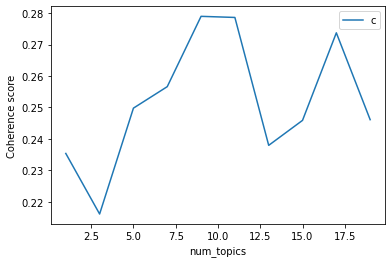

In [ ]:
lmlist, c_v, n = evaluate_graph(dictionary=corpus_bow.diccionario,
                                corpus=corpus_bow,
                                texts=textos_trigramas,
                                limit=20,
                                step=2)

### Determinar el tema dominante en cada documento
Una aplicación práctica del topic modeling es determinar de qué tema trata un documento.  
Para hacer esto, se busca el número de tema que tiene una mayor contribución en el documento.  
La función `format_topics_sentences()` genera esta información en forma de tabla.  

In [ ]:
def format_topics_sentences(ldamodel, corpus):
    # inicializa salida
    sent_topics_df = pd.DataFrame()

    # obtiene main topic de cada documento
    for row in ldamodel[corpus]:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        (topic_num, prop_topic)=row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.reset_index(inplace=True)
    sent_topics_df.columns = ['No_doc','Tema_dominante', 'Contribucion_per', 'Palabras_clave']
    sent_topics_df['Tema_dominante'] = sent_topics_df['Tema_dominante'].astype('int')
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_bow)

df_topic_sents_keywords.head(10)

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,0,0,0.9921,"year, people, australia, attack, fire, force, ..."
1,1,1,0.5178,"australian, australia, company, year, month, p..."
2,2,2,0.9687,"people, australia, attack, government, police,..."
3,3,3,0.9822,"year, palestinian, australian, israeli, austra..."
4,4,3,0.7111,"year, palestinian, australian, israeli, austra..."
5,5,2,0.7479,"people, australia, attack, government, police,..."
6,6,3,0.9899,"year, palestinian, australian, israeli, austra..."
7,7,0,0.9673,"year, people, australia, attack, fire, force, ..."
8,8,0,0.9930,"year, people, australia, attack, fire, force, ..."
9,9,0,0.9815,"year, people, australia, attack, fire, force, ..."


### Determinar el documento más representativo de cada tema
Agrupando por temas, podemos seleccionar el de mayor porcentaje como más representativo.

In [ ]:
# Agrupamos documentos por tema
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Tema_dominante')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Contribucion_per'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# cambiamos nombre de columna
sent_topics_sorted.columns = df_topic_sents_keywords.columns

# Mostramos
sent_topics_sorted

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,12,0,0.9938,"year, people, australia, attack, fire, force, ..."
1,179,1,0.9914,"australian, australia, company, year, month, p..."
2,105,2,0.9917,"people, australia, attack, government, police,..."
3,131,3,0.9932,"year, palestinian, australian, israeli, austra..."
4,200,4,0.9949,"government, palestinian, australian, people, o..."


### Distribución de temas entre documentos
Por último, podemos analizar el volumen y la distribución de temas entre los documentos del tema.  

In [ ]:
# núm de documentos por cada tema
topic_counts = df_topic_sents_keywords['Tema_dominante'].value_counts()

# porcentaje de documentos por cada tema
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# palabras clave de cada tema
topic_num_keywords = sent_topics_sorted[['Tema_dominante', 'Palabras_clave']]

# Concatenamos por columna
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# cambiamos nombre de columna
df_dominant_topics.columns = ['Tema_dominante', 'Palabras_clave', 'Num_Documentos', 'Perc_Documentos']

# Show
df_dominant_topics

,Tema_dominante,Palabras_clave,Num_Documentos,Perc_Documentos
0,0,"year, people, australia, attack, fire, force, ...",54,0.1800
1,1,"australian, australia, company, year, month, p...",56,0.1867
2,2,"people, australia, attack, government, police,...",62,0.2067
3,3,"year, palestinian, australian, israeli, austra...",65,0.2167
4,4,"government, palestinian, australian, people, o...",63,0.2100
